In [710]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator 
from yellowbrick.cluster import silhouette_visualizer 
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.datasets import make_blobs

from decimal import Decimal

In [711]:
data = pd.read_csv('../data/bike_clean.csv')

In [712]:
data.describe()

,Unnamed: 0,hour,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,4380.500000,11.500000,704.602055,12.882922,58.226256,1.724909,14368.257991,4.073813,0.569111,0.148687,0.750685
std,2528.938512,6.922582,644.997468,11.944825,20.362413,1.036300,6082.987120,13.060369,0.868746,1.128193,4.367462
min,1.000000,0.000000,0.000000,-17.800000,0.000000,0.000000,270.000000,-30.600000,0.000000,0.000000,0.000000
25%,2190.750000,5.750000,191.000000,3.500000,42.000000,0.900000,9400.000000,-4.700000,0.000000,0.000000,0.000000
50%,4380.500000,11.500000,504.500000,13.700000,57.000000,1.500000,16980.000000,5.100000,0.010000,0.000000,0.000000
75%,6570.250000,17.250000,1065.250000,22.500000,74.000000,2.300000,20000.000000,14.800000,0.930000,0.000000,0.000000
max,8760.000000,23.000000,3556.000000,39.400000,98.000000,7.400000,20000.000000,27.200000,3.520000,35.000000,88.000000


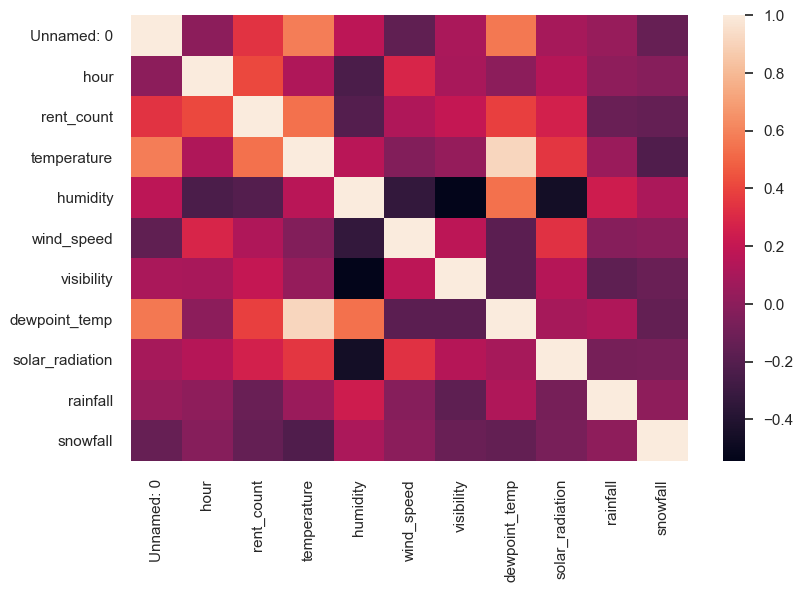

In [713]:
sns.heatmap(data.corr())
plt.show()

## K means clustering
### Scaling Data

In [714]:
# drop categorical var: holiday, season, open
# drop humidity (correlated with solar and visibility)
# drop dewpoint_temp (correlated with temperature
# drop rainfall & snowfall (more than 93% is 0)

In [715]:
df_kmean = data.drop(columns = ['Unnamed: 0','holiday', 'season', 'open', 'datetime', 'date', 'humidity','dewpoint_temp',
                               'rainfall', 'snowfall'])

In [716]:
df_kmean.columns

Index(['hour', 'rent_count', 'temperature', 'wind_speed', 'visibility',
       'solar_radiation'],
      dtype='object')

In [717]:
df_kmean.describe()

,hour,rent_count,temperature,wind_speed,visibility,solar_radiation
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,11.500000,704.602055,12.882922,1.724909,14368.257991,0.569111
std,6.922582,644.997468,11.944825,1.036300,6082.987120,0.868746
min,0.000000,0.000000,-17.800000,0.000000,270.000000,0.000000
25%,5.750000,191.000000,3.500000,0.900000,9400.000000,0.000000
50%,11.500000,504.500000,13.700000,1.500000,16980.000000,0.010000
75%,17.250000,1065.250000,22.500000,2.300000,20000.000000,0.930000
max,23.000000,3556.000000,39.400000,7.400000,20000.000000,3.520000


In [718]:
dataarray = df_kmean.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) 
scaled_features

array([[-1.66132477, -0.69865046, -1.51395724,  0.45847578,  0.92587135,
        -0.65513172],
       [-1.51686175, -0.77617457, -1.53907415, -0.8925615 ,  0.92587135,
        -0.65513172],
       [-1.37239873, -0.82423951, -1.58093567, -0.69955617,  0.92587135,
        -0.65513172],
       ...,
       [ 1.37239873, -0.0164383 , -0.86091752, -1.37507481,  0.87326261,
        -0.65513172],
       [ 1.51686175,  0.01147038, -0.90277904, -0.69955617,  0.6940641 ,
        -0.65513172],
       [ 1.66132477, -0.18699134, -0.91952365, -0.41004818,  0.77626525,
        -0.65513172]])

### Evaluating WCSS

In [719]:
wcss = []
max_k = 14
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

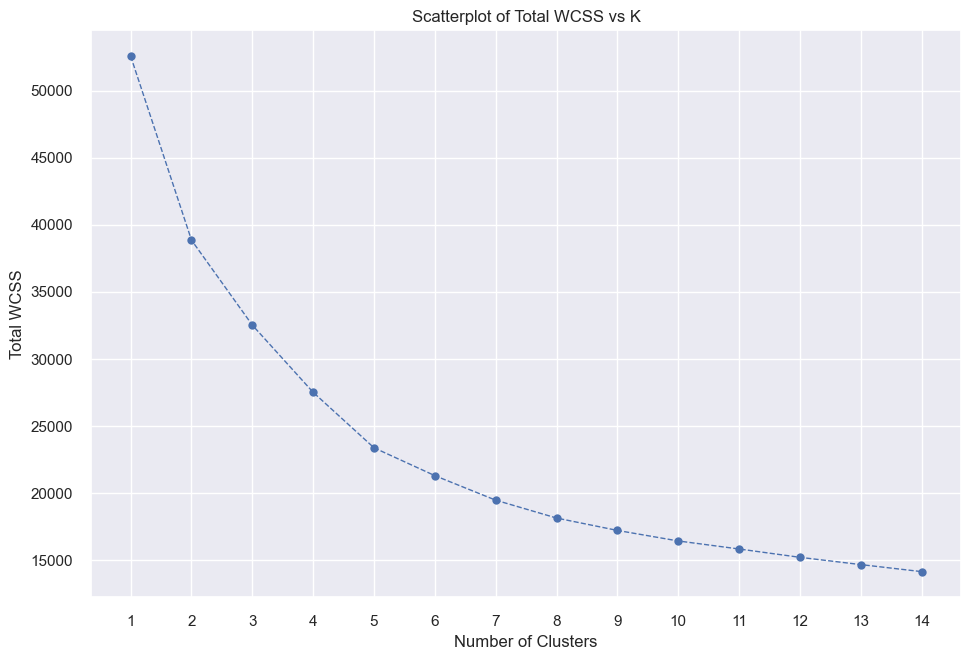

In [720]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [721]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

5

In [722]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

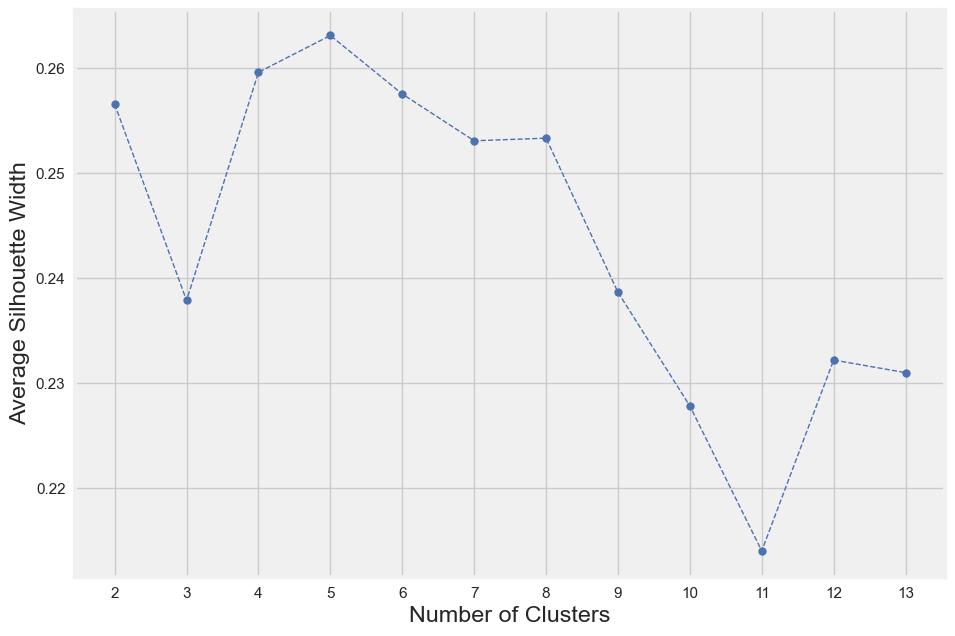

In [723]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [726]:
silhouette_dict = {}
def kmeans_label(data, num_clusters): 
    kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data.to_numpy()) 
    kmeans_model.fit(scaled_features)
    data2 = data.copy()
    labels = kmeans_model.labels_
    data2['Clusters'] = pd.DataFrame(labels)
    return data2

def plot_boxplots(data_with_label):
    plt.figure(figsize=(30,30))
    sns.set(font_scale = 2)
    for i in range(len(data_with_label.columns)-1):
        plt.subplot(2,5,i+1)
        sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 
    
def plot_silhouettes(data,num_clusters):
    scaler = StandardScaler()
    dataarray = scaler.fit_transform(data.to_numpy()) 
    model = KMeans(num_clusters,random_state=42)
    plt.figure(figsize=(10, 7)) 
    sns.set(font_scale = 1)
    silhouette_visualizer(model, dataarray, colors='yellowbrick')
    score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
    if num_clusters not in silhouette_dict.keys():
        silhouette_dict[num_clusters] = score
    print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

In [727]:
kmeans5 = KMeans(init="random",n_clusters =5 , random_state = 42)
kmeans5.fit(scaled_features)
clustergroups5 = kmeans5.labels_
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_)
Clustercenters5

print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups5)}')

CH score: 2730.3254618479536


In [348]:
model5 = kmeans_label(df_kmean, 5)
model5.head()
model5.Clusters.value_counts()

4.0    1964
3.0    1872
0.0    1478
1.0    1439
2.0    1417
Name: Clusters, dtype: int64

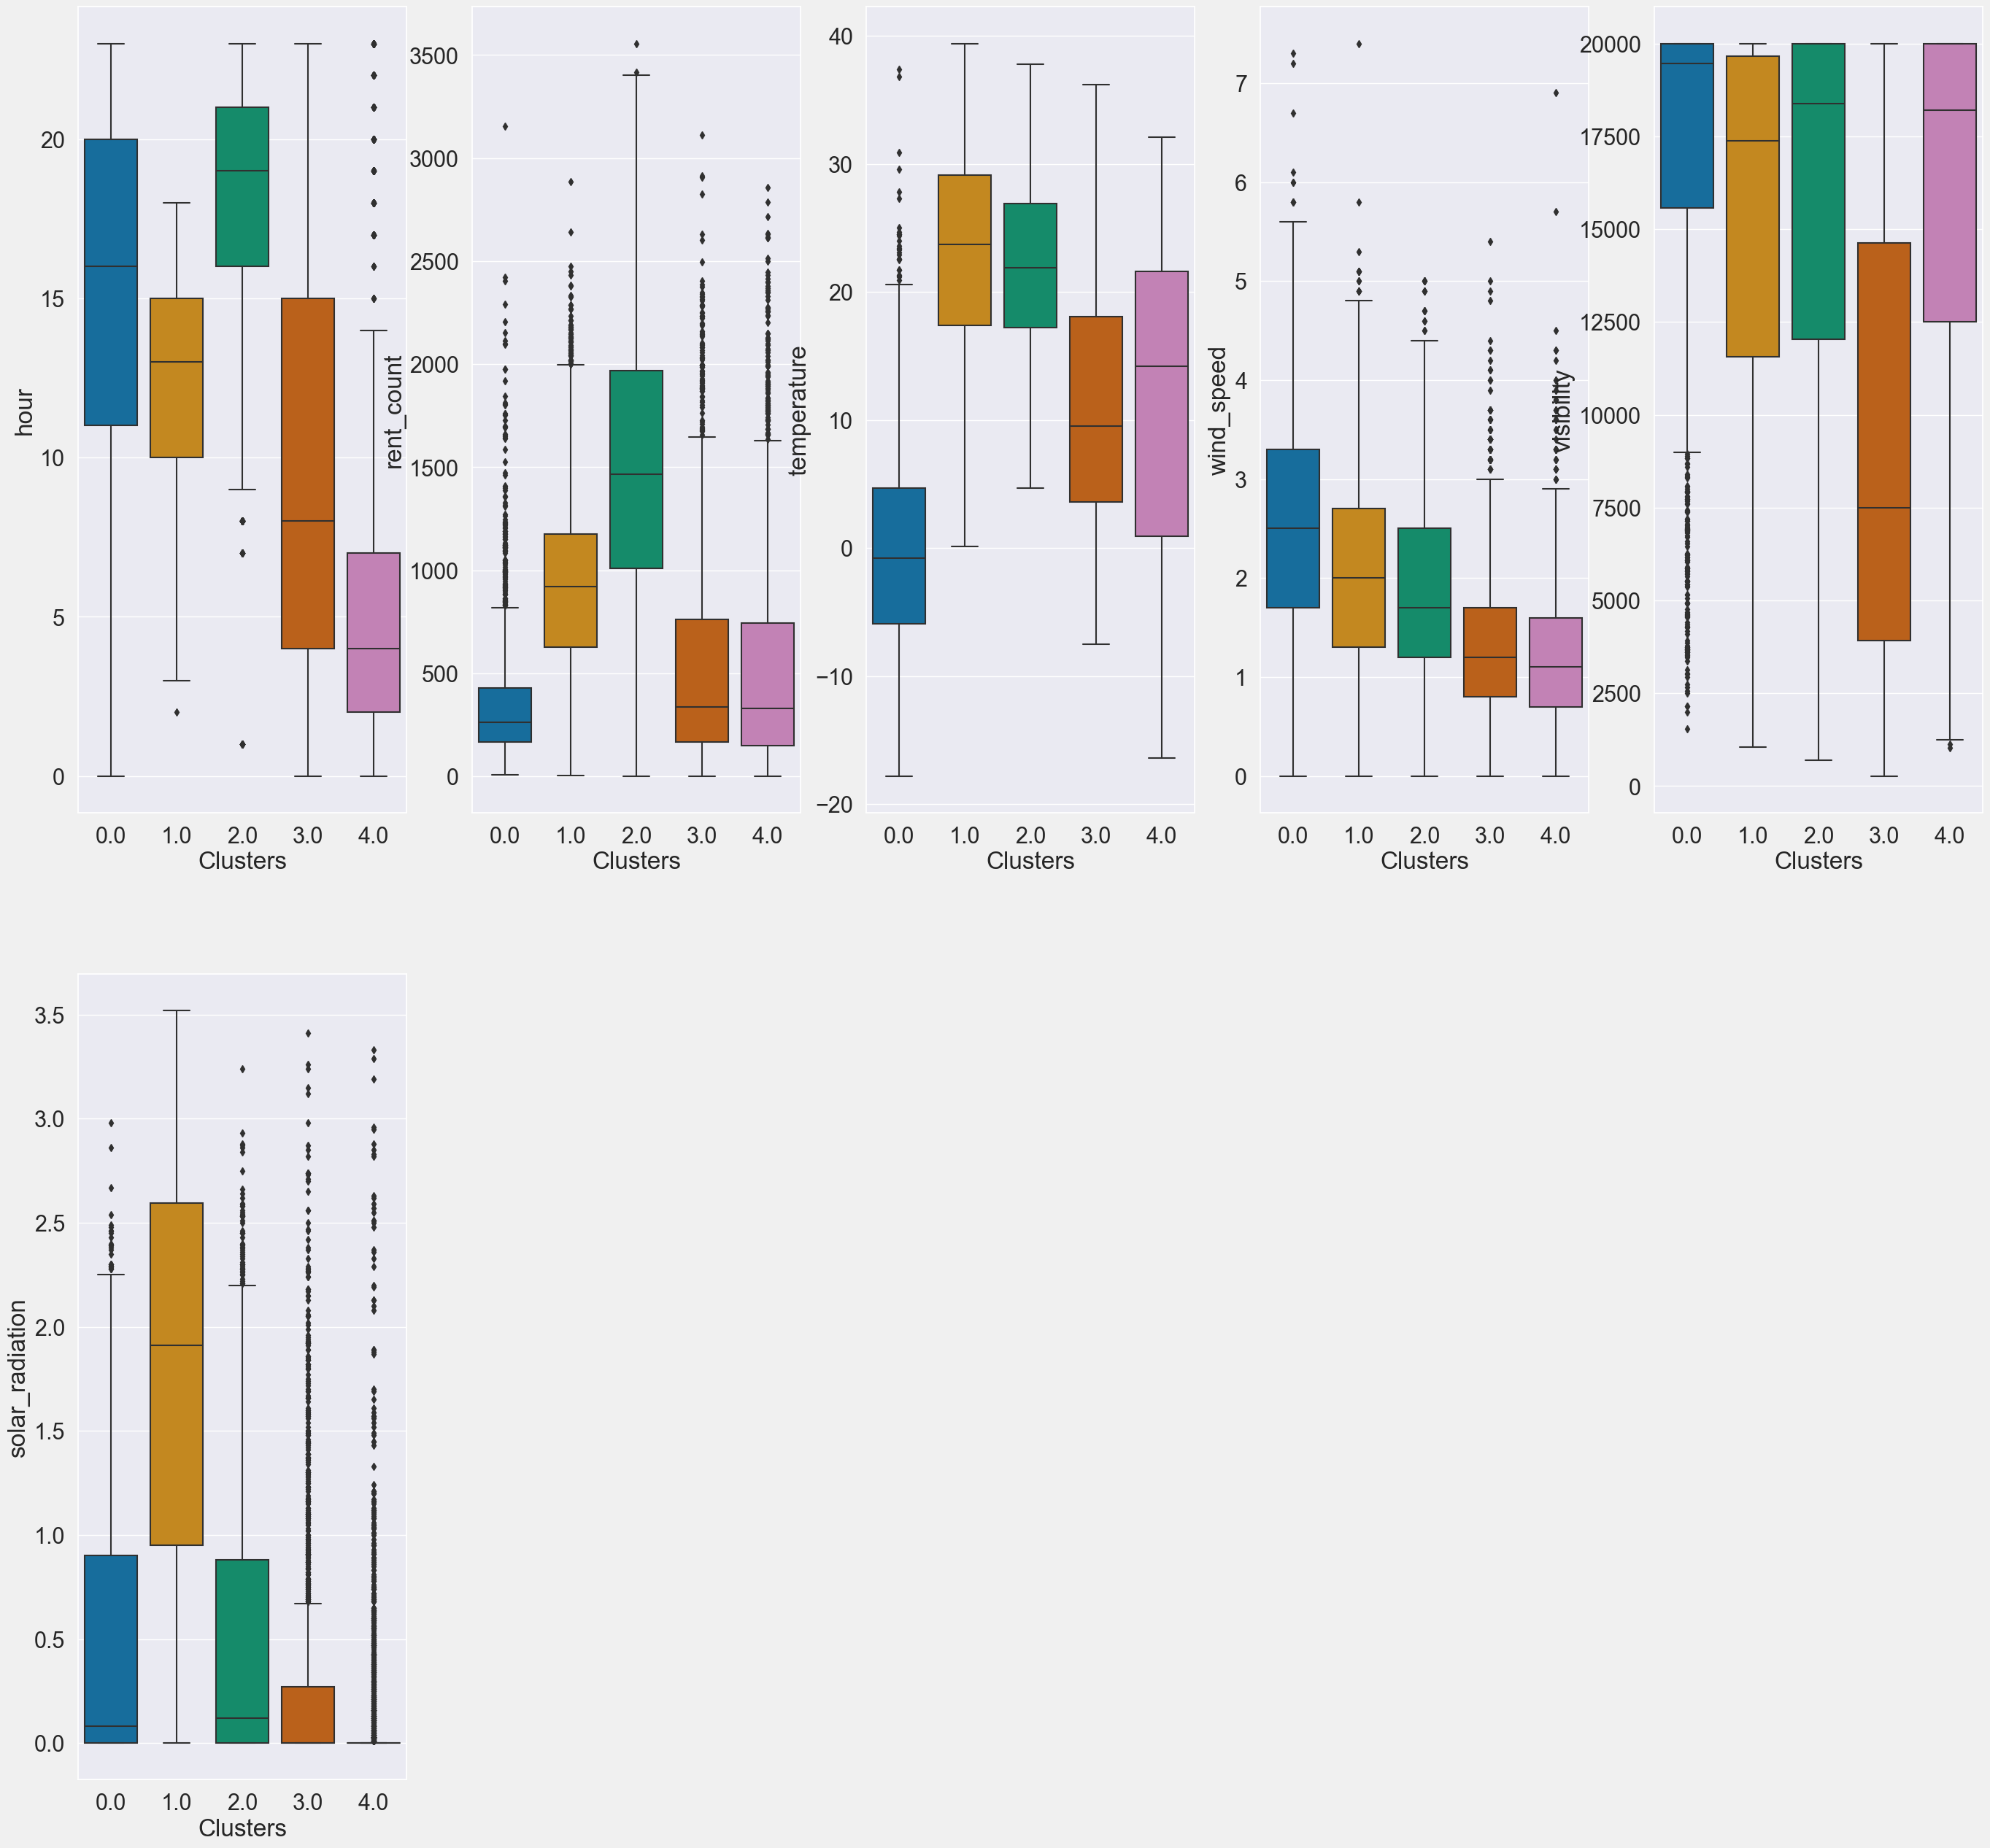

In [349]:
plot_boxplots(model5)
plt.show()

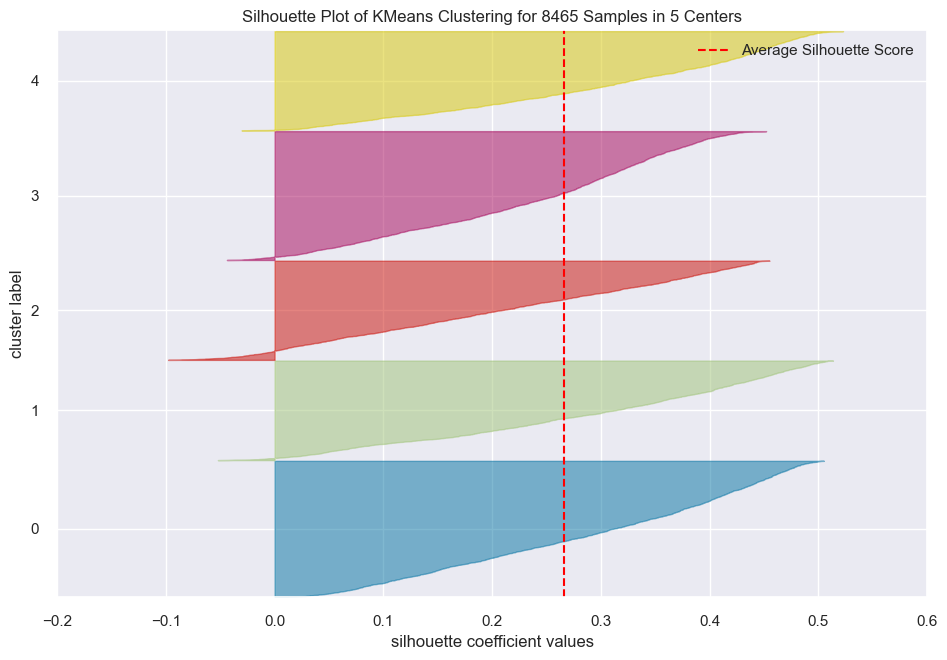

For n_clusters = 5 The average silhouette_score is: 0.26577330587068476 


In [350]:
plot_silhouettes(df_kmean,5)
plt.show()

### Kmeans with 5 clusters

In [728]:
kmeans5 = KMeans(init="random",n_clusters = 5 , random_state = 42)
kmeans5.fit(scaled_features)
clustergroups5 = kmeans5.labels_
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_)
Clustercenters5

,0,1,2,3,4,5
0,1.040619,1.570668,0.707524,0.008864,0.375439,-0.321569
1,0.576226,-0.585371,-1.061411,0.930191,0.527842,-0.177023
2,-1.021550,-0.499842,-0.163805,-0.622839,0.514385,-0.542537
3,0.212586,0.477542,0.887103,0.526782,0.277755,1.828807
4,-0.286598,-0.542212,-0.210074,-0.463491,-1.445874,-0.450054


In [729]:
model5 = kmeans_label(df_kmean, 5)
model5.head()

,hour,rent_count,temperature,wind_speed,visibility,solar_radiation,Clusters
0,0,254,-5.2,2.2,20000,0.0,2
1,1,204,-5.5,0.8,20000,0.0,2
2,2,173,-6.0,1.0,20000,0.0,2
3,3,107,-6.2,0.9,20000,0.0,2
4,4,78,-6.0,2.3,20000,0.0,1


In [730]:
model5.Clusters.value_counts(dropna=False)

2    2150
4    2018
1    1555
3    1547
0    1490
Name: Clusters, dtype: int64

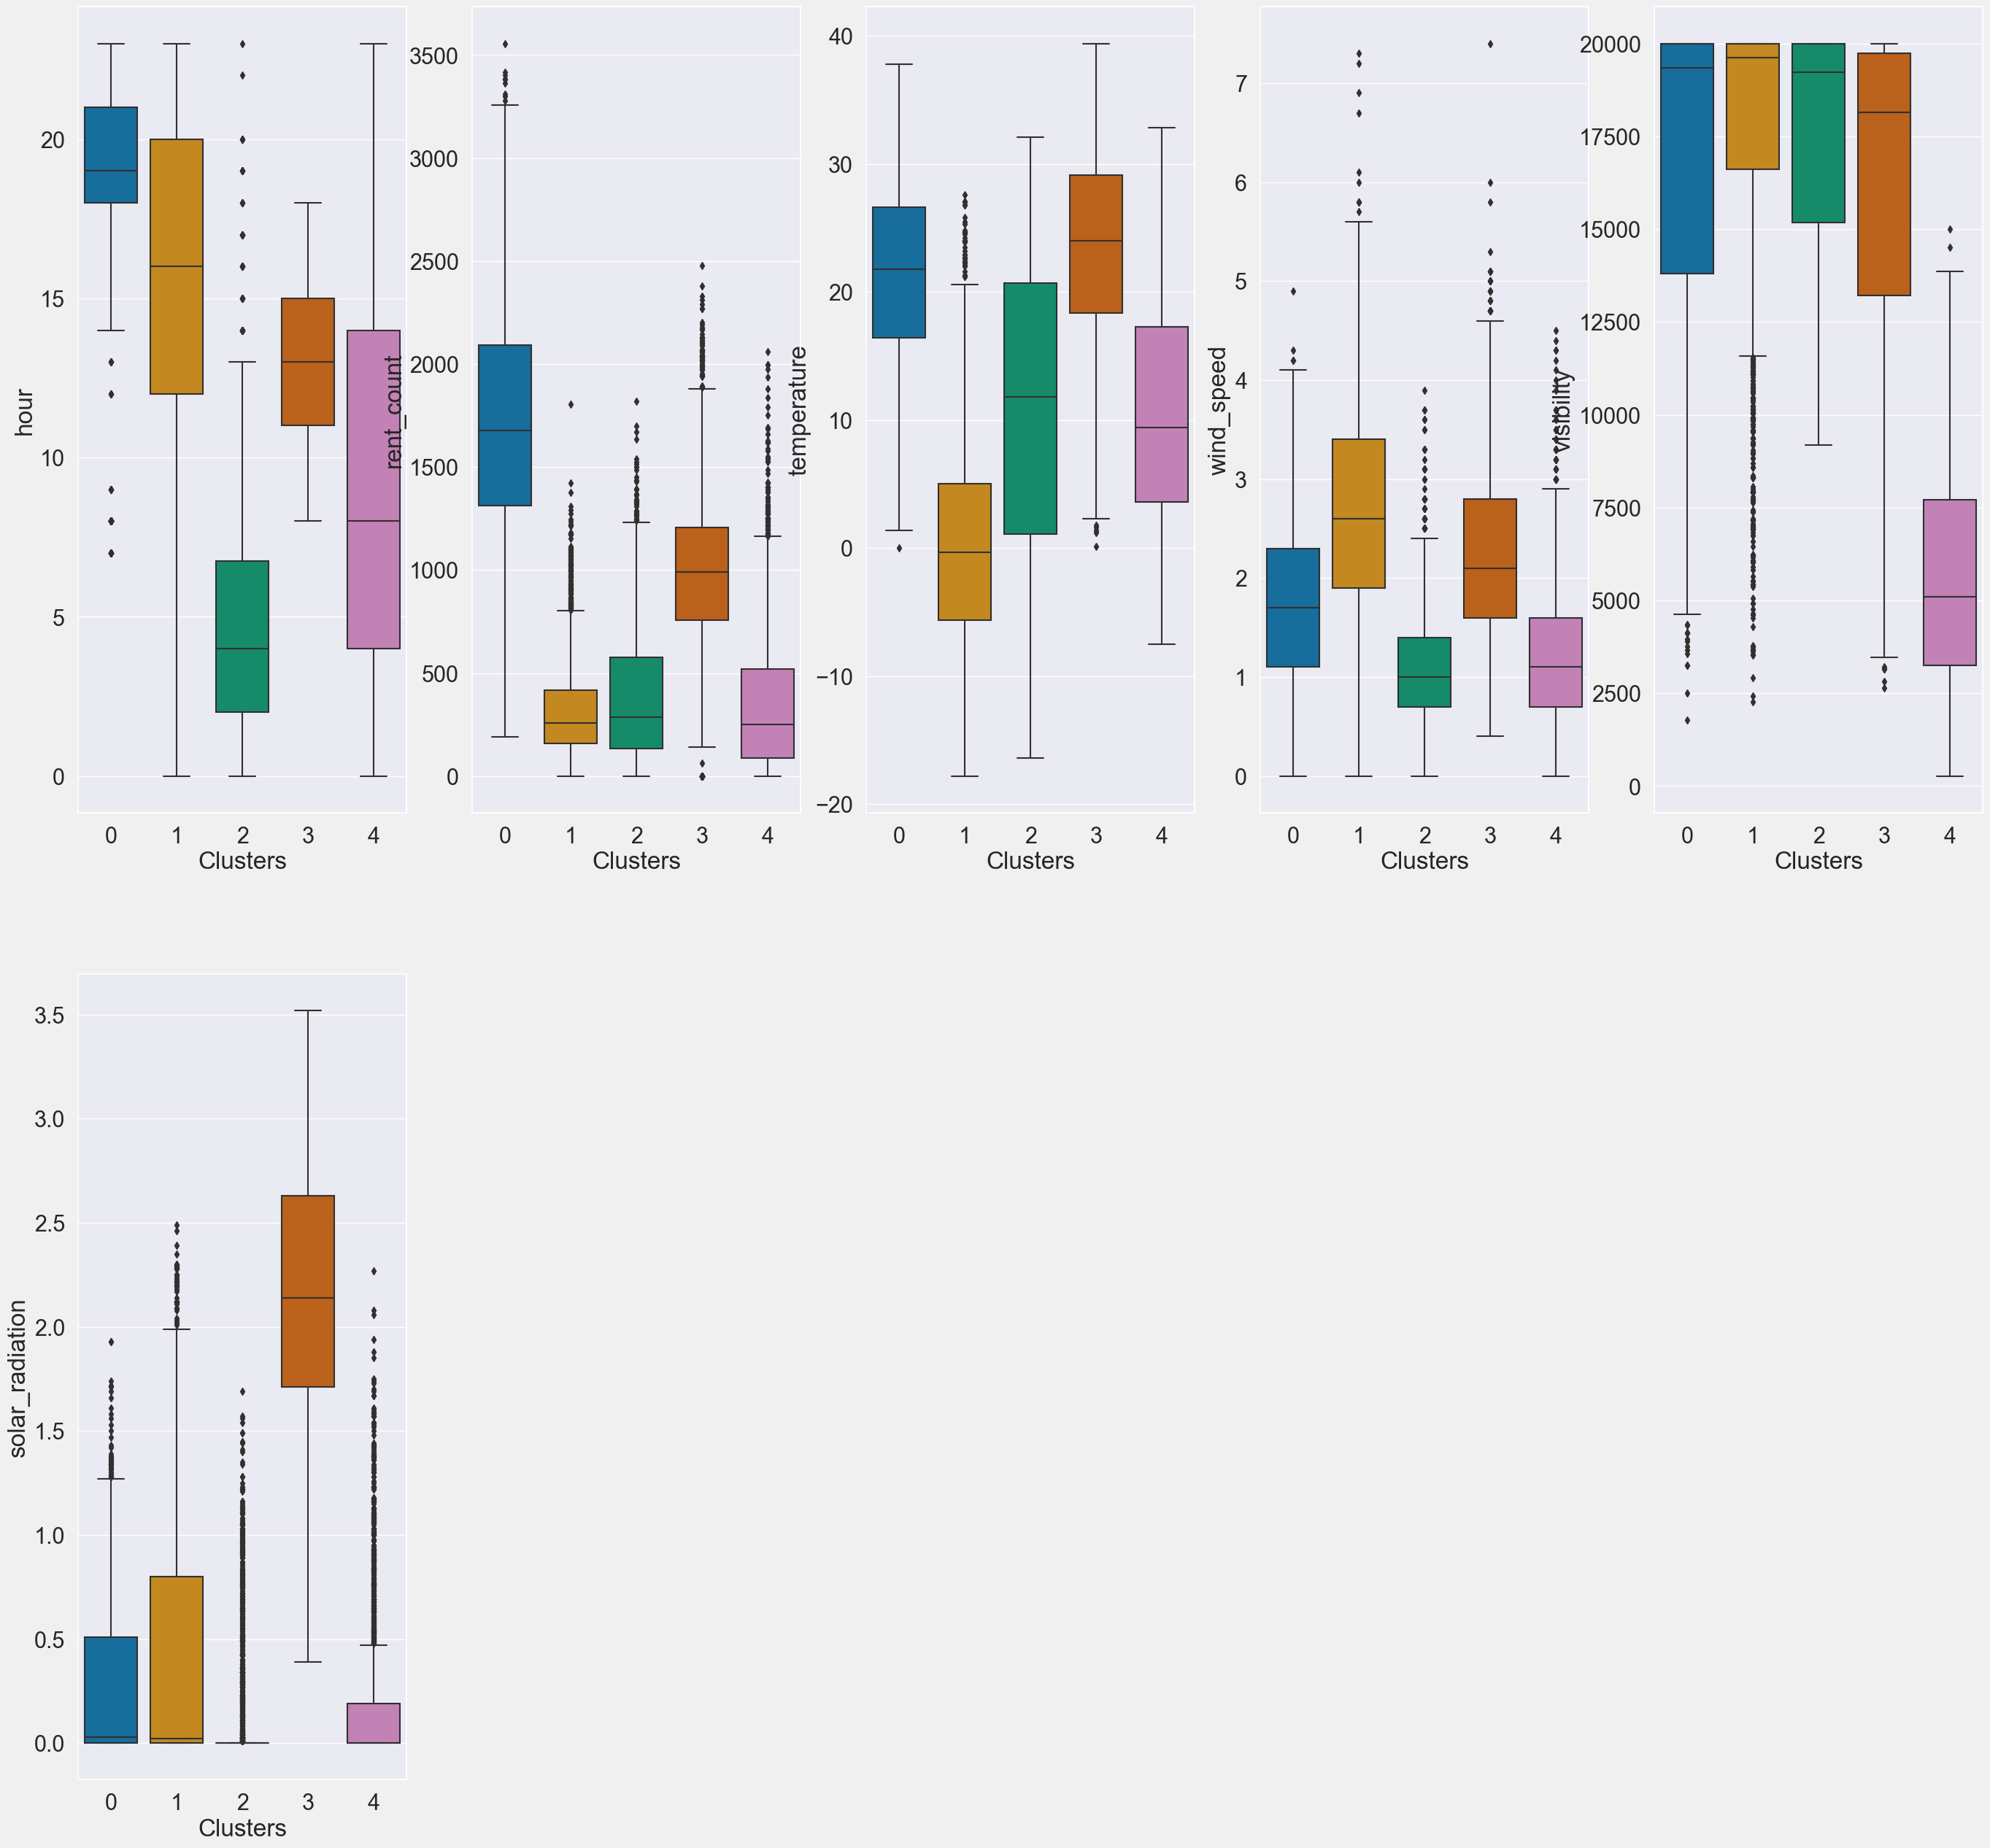

In [731]:
plot_boxplots(model5)
plt.show()

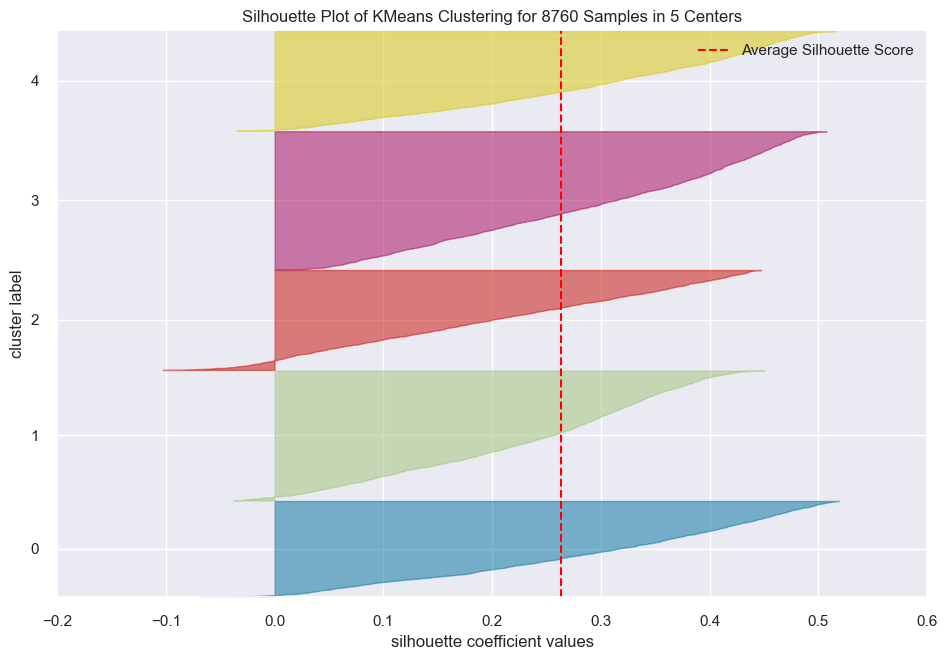

For n_clusters = 5 The average silhouette_score is: 0.2631052562486528 


In [732]:
plot_silhouettes(df_kmean,5)
plt.show()

In [742]:
Clustercenters5 = pd.DataFrame(scaler.inverse_transform(kmeans5.cluster_centers_), columns = df_kmean.columns)

In [749]:
Clustercenters5

,hour,rent_count,temperature,wind_speed,visibility,solar_radiation
0,18.703356,1717.620805,21.333691,1.734094,16651.919463,0.289765
1,15.488746,327.061093,0.205273,2.688810,17578.932476,0.415331
2,4.428638,382.223617,10.926406,1.079498,17497.075779,0.097810
3,12.971558,1012.597931,23.478604,2.270782,16057.744021,2.157789
4,9.516113,354.896877,10.373773,1.244621,5573.525037,0.178151


In [743]:
pca_final_cluster = pd.concat([model5, data[['season', 'holiday', 'open']]], axis = 1)

In [744]:
pca_season = pca_final_cluster.groupby('Clusters').season.agg(pd.Series.mode).to_frame()

In [745]:
pca_holiday = pca_final_cluster.groupby('Clusters').holiday.agg(pd.Series.mode).to_frame()

In [746]:
pca_open = pca_final_cluster.groupby('Clusters').open.agg(pd.Series.mode).to_frame()

In [747]:
final_pca_cluster = pd.concat([Clustercenters5,pca_season, pca_holiday, pca_open], axis=1)
final_pca_cluster

,hour,rent_count,temperature,wind_speed,visibility,solar_radiation,season,holiday,open
0,18.703356,1717.620805,21.333691,1.734094,16651.919463,0.289765,Summer,No Holiday,Yes
1,15.488746,327.061093,0.205273,2.688810,17578.932476,0.415331,Winter,No Holiday,Yes
2,4.428638,382.223617,10.926406,1.079498,17497.075779,0.097810,Autumn,No Holiday,Yes
3,12.971558,1012.597931,23.478604,2.270782,16057.744021,2.157789,Summer,No Holiday,Yes
4,9.516113,354.896877,10.373773,1.244621,5573.525037,0.178151,Spring,No Holiday,Yes


### PCA

In [750]:
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from yellowbrick.features import PCA as YBPCA
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [751]:
bike = pd.read_csv('../PCA/bike_season_as_no.csv')

In [752]:
bike

,Unnamed: 0,datetime,date,hour,season,holiday,open,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall,season_no
0,1,2017-12-01 00:00:00,2017-12-01,0,Winter,No Holiday,Yes,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0,4
1,2,2017-12-01 01:00:00,2017-12-01,1,Winter,No Holiday,Yes,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0,4
2,3,2017-12-01 02:00:00,2017-12-01,2,Winter,No Holiday,Yes,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0,4
3,4,2017-12-01 03:00:00,2017-12-01,3,Winter,No Holiday,Yes,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0,4
4,5,2017-12-01 04:00:00,2017-12-01,4,Winter,No Holiday,Yes,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,2018-11-30 19:00:00,2018-11-30,19,Autumn,No Holiday,Yes,1003,4.2,34,2.6,18940,-10.3,0.0,0.0,0,3
8756,8757,2018-11-30 20:00:00,2018-11-30,20,Autumn,No Holiday,Yes,764,3.4,37,2.3,20000,-9.9,0.0,0.0,0,3
8757,8758,2018-11-30 21:00:00,2018-11-30,21,Autumn,No Holiday,Yes,694,2.6,39,0.3,19680,-9.9,0.0,0.0,0,3
8758,8759,2018-11-30 22:00:00,2018-11-30,22,Autumn,No Holiday,Yes,712,2.1,41,1.0,18590,-9.8,0.0,0.0,0,3


In [753]:
bike3 = bike.drop(columns = ['Unnamed: 0', 'season','datetime','date','holiday','open'],inplace=False)

In [754]:
bike3.drop(columns = ['season_no', 'hour', 'rent_count'], inplace = True)
bike3.head()

,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,-6.0,36,2.3,20000,-18.6,0.0,0.0,0


In [755]:
_ , p_value = calculate_bartlett_sphericity(bike3)
p_value

0.0

KMO Test

In [756]:
_, kmo_score = calculate_kmo(bike3)
kmo_score 

0.43140263650368643

In [757]:
colnames = list(bike3.columns)
scaler = StandardScaler(with_mean=True,with_std=True)
scaled_features = pd.DataFrame(scaler.fit_transform(bike3))

scaled_features.columns = colnames

In [758]:
N = len(bike3.columns)
pca = PCA(n_components=N)
pca.fit(scaled_features)

PCA(n_components=8)

In [759]:
#outputs an array of the variance explained by each component scaled to the total of 1.
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([0.30078131, 0.24489562, 0.13307838, 0.11703819, 0.09495013,
       0.08034028, 0.02834569, 0.00057041])

In [760]:
# Cumulative sum of principal components i.e. Cumulative variance of 2 = PC1 variance + PC2 variance
cumulative_variance = np.cumsum(np.round(explained_variance_ratio, decimals=3))
cumulative_variance

array([0.301, 0.546, 0.679, 0.796, 0.891, 0.971, 0.999, 1.   ])

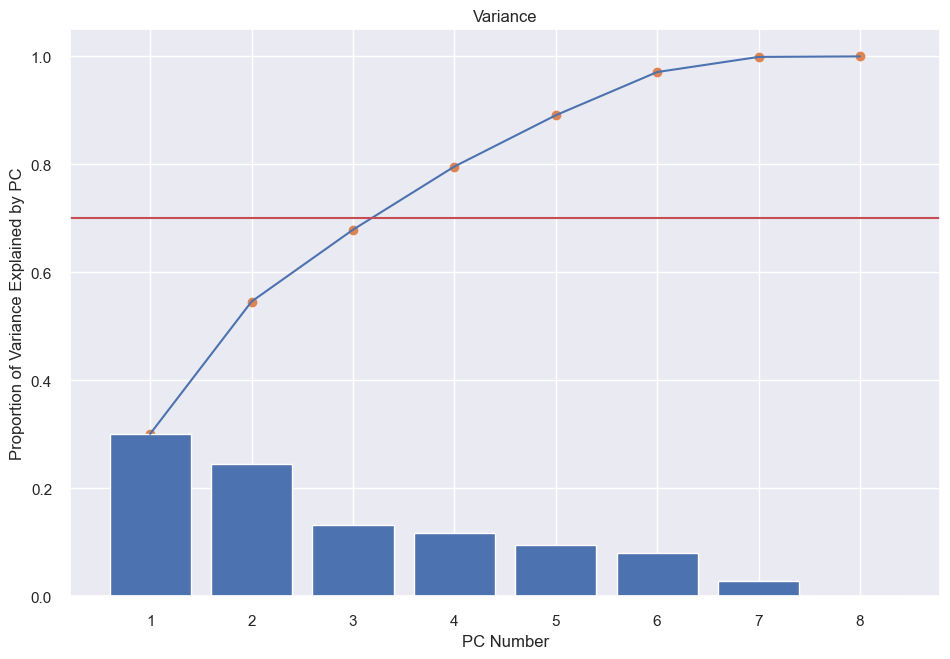

In [761]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance_ratio)
plt.scatter(range(1,N+1),cumulative_variance)
plt.plot(x,cumulative_variance)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color = 'r')
plt.show()

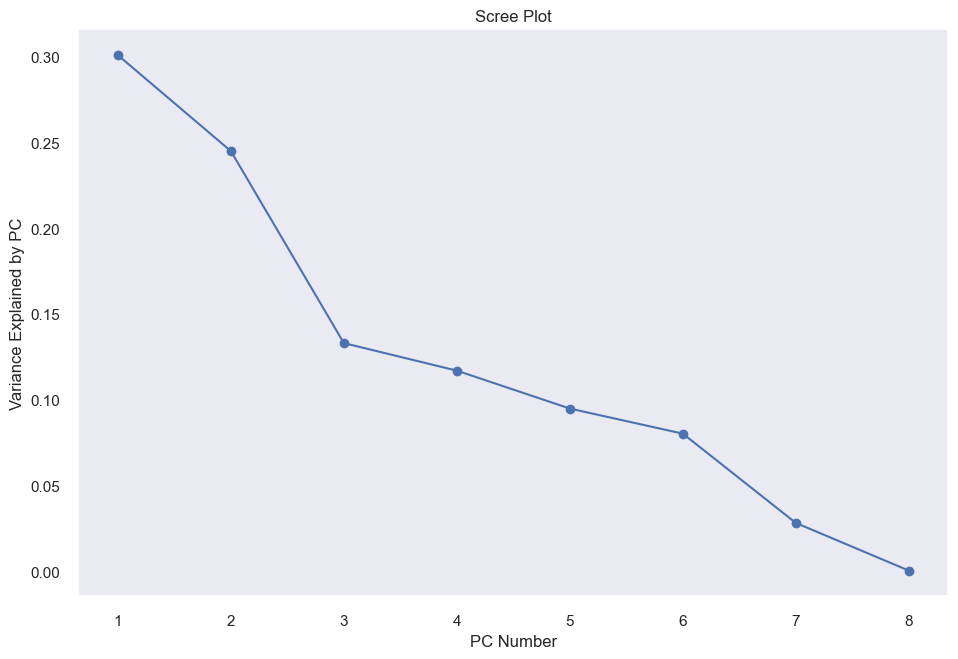

In [762]:
#Scree Plot 
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),pca.explained_variance_ratio_)
plt.plot(range(1,N+1),pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()
plt.show()

In [763]:
kl = KneeLocator(range(1, N+1), pca.explained_variance_ratio_, curve="convex", direction="decreasing")

kl.elbow

3

PCA on Scaled Features

In [764]:
# factor analysis
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x): #helper functions to suppress loading less than 0.7 
    #a gradual process to lead to this function
    # if x<=-0.5, we drop the variable
        if x <= -0.5 or x >= 0.5: #Adjust the threshold value 
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax') #Conduct PCA + varimax rotation to extract latent factors 
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    
    df_pca = f.transform(data)
    return loadings, df_pca

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

In [765]:
def CronbachAlpha(itemscores): #calculate the CronbachAlpha to see how closely related a set of items are as a group
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [766]:
pca_label, df_pca_array = evaluate_pcs(3,scaled_features[colnames])
pca_label

,PC1,PC2,PC3
temperature,0.957515,,
humidity,,-0.626264,0.570887
wind_speed,,0.767136,
visibility,,,-0.680776
dewpoint_temp,0.952847,,
solar_radiation,,0.788631,
rainfall,,,0.607358
snowfall,,,0.526117


In [767]:
print(CronbachAlpha(scaled_features[['temperature','dewpoint_temp']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['wind_speed','solar_radiation']])) #Reliability of PC2
print(CronbachAlpha(scaled_features[['rainfall','snowfall', 'humidity']]))

0.9544114060820124
0.4988075795907545
0.285805107460933


In [768]:
df_pca = pd.DataFrame(df_pca_array
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
df_pca

,principal component 1,principal component 2,principal component 3
0,-1.596561,0.090012,-0.761112
1,-1.526320,-0.615972,-1.084805
2,-1.553523,-0.534400,-1.021280
3,-1.546673,-0.598820,-1.030877
4,-1.670405,0.148668,-0.750271
...,...,...,...
8755,-1.044885,0.377591,-0.642781
8756,-1.027140,0.189011,-0.747777
8757,-0.937913,-0.832176,-1.177562
8758,-0.981443,-0.524627,-0.899528


In [769]:
df_pca_kmean = pd.concat([df_pca, bike[['hour', 'rent_count']]], axis = 1)

In [770]:
dataarray = df_pca_kmean.to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataarray) 
scaled_features

array([[-1.59656115,  0.09001232, -0.76111161, -1.66132477, -0.69865046],
       [-1.52632007, -0.61597151, -1.08480548, -1.51686175, -0.77617457],
       [-1.55352305, -0.53439983, -1.02127981, -1.37239873, -0.82423951],
       ...,
       [-0.93791261, -0.83217599, -1.17756193,  1.37239873, -0.0164383 ],
       [-0.98144282, -0.52462737, -0.89952771,  1.51686175,  0.01147038],
       [-0.97682739, -0.40298311, -0.83423547,  1.66132477, -0.18699134]])

In [771]:
pd.DataFrame(scaled_features).describe()

,0,1,2,3,4
count,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03
mean,1.297795e-17,-2.271141e-17,-1.297795e-17,2.027805e-19,3.893385e-17
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,-4.410783e+00,-1.764999e+00,-1.620641e+00,-1.661325e+00,-1.092473e+00
25%,-6.869152e-01,-7.859742e-01,-6.157336e-01,-8.306624e-01,-7.963308e-01
50%,1.176111e-01,-2.358633e-01,-2.463947e-01,0.000000e+00,-3.102547e-01
75%,8.150901e-01,6.588490e-01,3.911369e-01,8.306624e-01,5.591782e-01
max,1.893424e+00,5.213725e+00,1.571865e+01,1.661325e+00,4.421042e+00


### Evaluating WCSS

In [772]:
wcss = []
max_k = 14
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

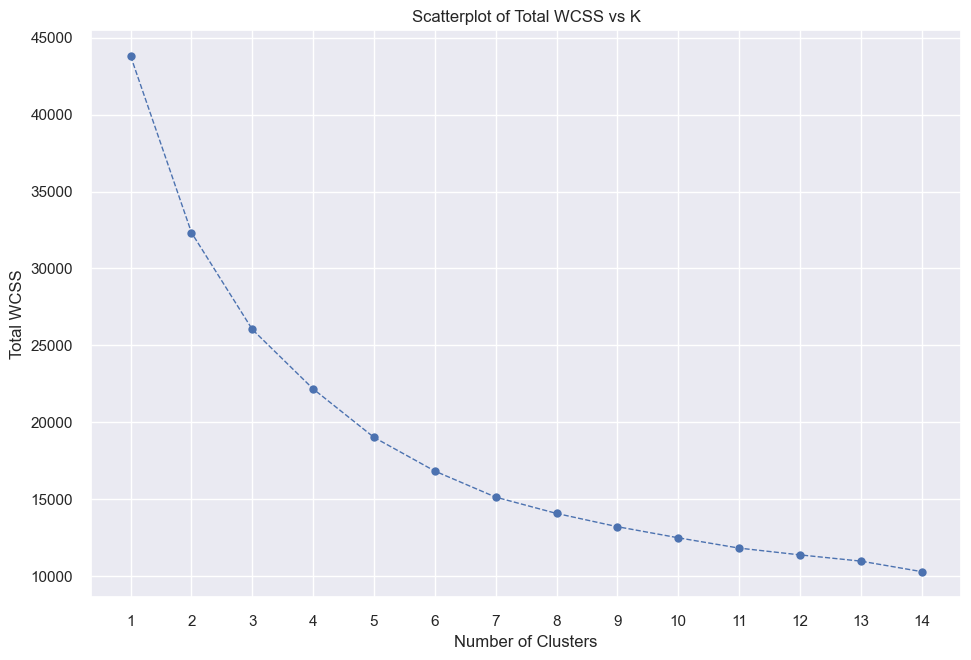

In [773]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [774]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

5

In [775]:
silhouette_coefficients = []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients.append(score)

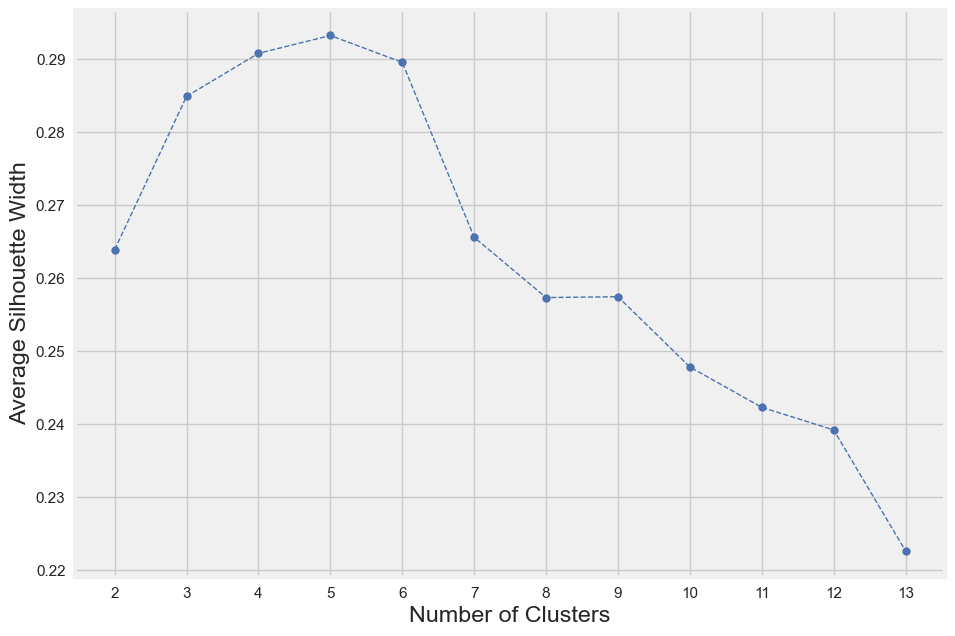

In [776]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [777]:
silhouette_dict = {}
def kmeans_label(data, num_clusters): 
    kmeans_model = KMeans(init = 'random', n_clusters = num_clusters, random_state=42)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(data.to_numpy()) 
    kmeans_model.fit(scaled_features)
    data2 = data.copy()
    labels = kmeans_model.labels_
    data2['Clusters'] = pd.DataFrame(labels)
    return data2

def plot_boxplots(data_with_label):
    plt.figure(figsize=(30,30))
    sns.set(font_scale = 2)
    for i in range(len(data_with_label.columns)-1):
        plt.subplot(2,5,i+1)
        sns.boxplot(y=data_with_label.columns[i], x='Clusters', data=data_with_label, palette="colorblind") 
    
def plot_silhouettes(data,num_clusters):
    scaler = StandardScaler()
    dataarray = scaler.fit_transform(data.to_numpy()) 
    model = KMeans(num_clusters,random_state=42)
    plt.figure(figsize=(10, 7)) 
    sns.set(font_scale = 1)
    silhouette_visualizer(model, dataarray, colors='yellowbrick')
    score = silhouette_score(dataarray, model.labels_,metric = 'euclidean')
    if num_clusters not in silhouette_dict.keys():
        silhouette_dict[num_clusters] = score
    print("For n_clusters = {0} The average silhouette_score is: {1} ".format(num_clusters,score))

### Kmeans with 5 clusters

In [778]:
kmeans5 = KMeans(init="random",n_clusters =5 , random_state = 42)
kmeans5.fit(scaled_features)
clustergroups5 = kmeans5.labels_
Clustercenters5 = pd.DataFrame(kmeans5.cluster_centers_)
Clustercenters5

print(f'CH score: {calinski_harabasz_score(scaled_features, clustergroups5)}')

CH score: 2851.041121084914


In [779]:
model5 = kmeans_label(df_pca_kmean, 5)
model5.head()

,principal component 1,principal component 2,principal component 3,hour,rent_count,Clusters
0,-1.596561,0.090012,-0.761112,0,254,1
1,-1.526320,-0.615972,-1.084805,1,204,1
2,-1.553523,-0.534400,-1.021280,2,173,1
3,-1.546673,-0.598820,-1.030877,3,107,1
4,-1.670405,0.148668,-0.750271,4,78,3


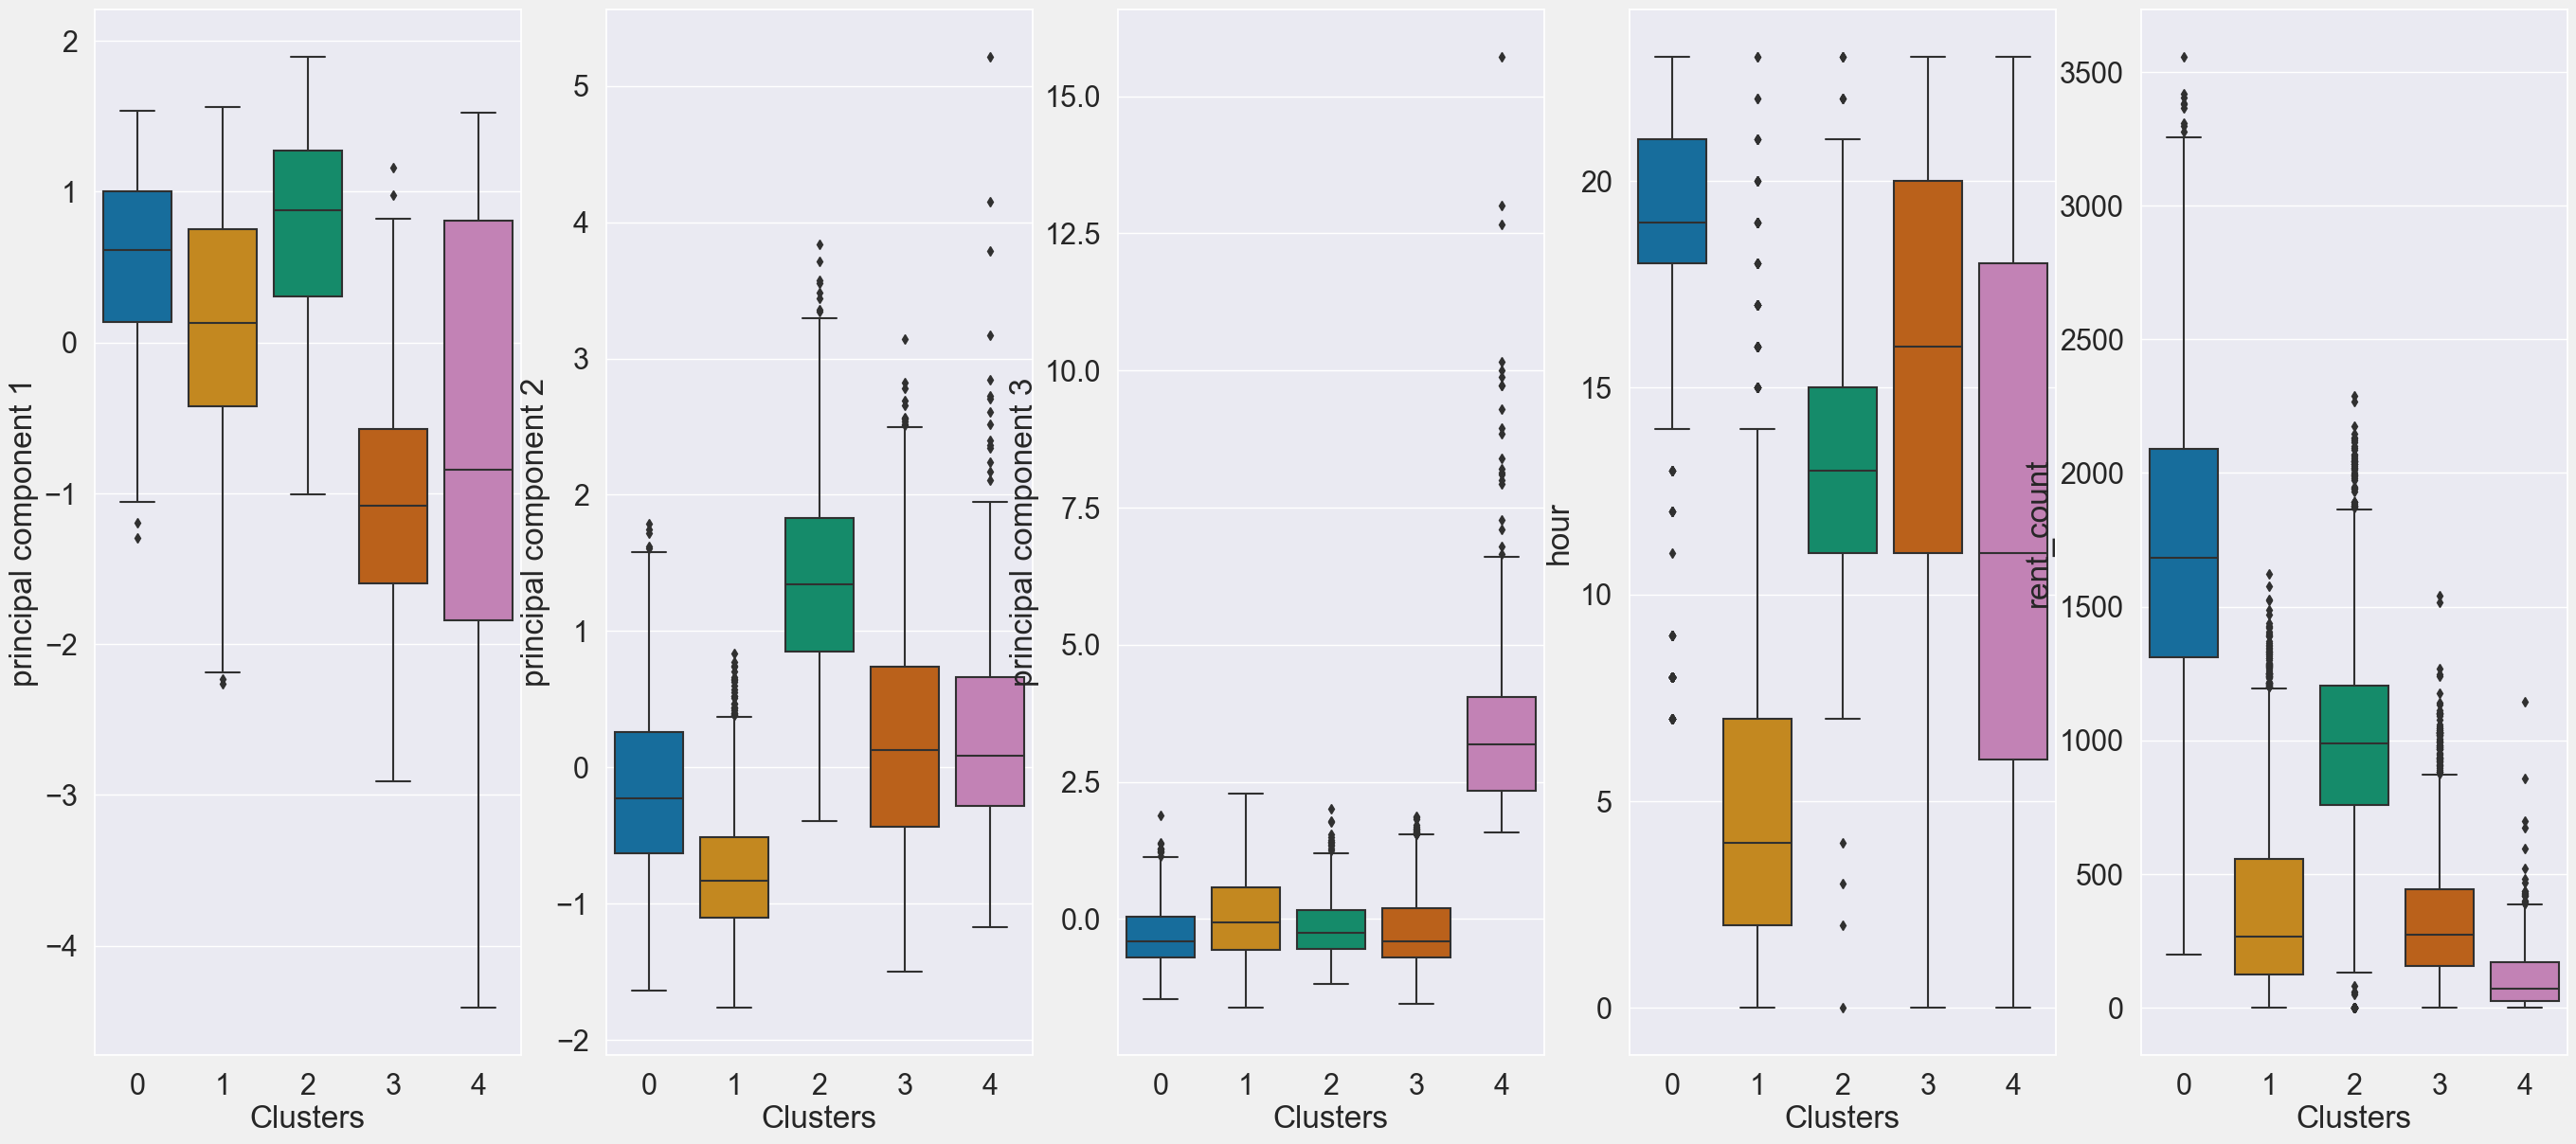

In [780]:
plot_boxplots(model5)
plt.show()

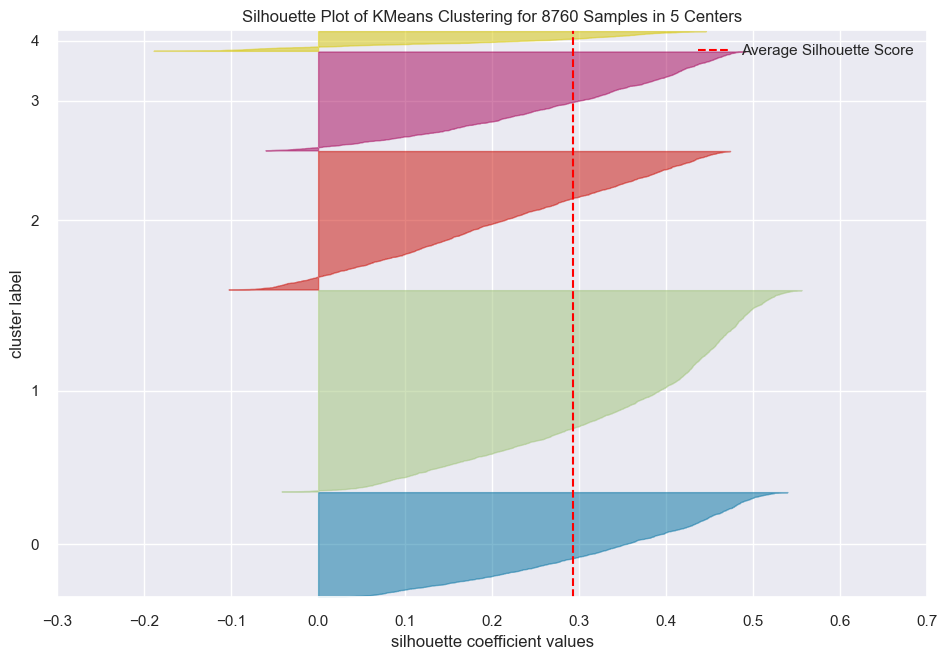

For n_clusters = 5 The average silhouette_score is: 0.29327842381412367 


In [781]:
plot_silhouettes(df_pca_kmean,5)
plt.show()

In [782]:
model5.Clusters.value_counts(dropna=False)

1    3134
3    2159
2    1628
0    1537
4     302
Name: Clusters, dtype: int64

In [783]:
clustergroups5 = kmeans5.labels_
Clustercenters5 = pd.DataFrame(scaler.inverse_transform(kmeans5.cluster_centers_), columns = df_pca_kmean.columns)

In [784]:
Clustercenters5

,principal component 1,principal component 2,principal component 3,hour,rent_count
0,0.551316,-0.167563,-0.293088,18.582575,1717.084525
1,0.115906,-0.787708,0.027354,4.645388,369.466645
2,0.789496,1.346151,-0.160218,13.049785,1001.746773
3,-1.070535,0.209575,-0.217457,15.201758,326.823230
4,-0.605121,0.274166,3.640100,11.704319,125.554817


In [785]:
pca_final_cluster = pd.concat([model5, bike[['season', 'holiday', 'open']]], axis = 1)

In [786]:
pca_season = pca_final_cluster.groupby('Clusters').season.agg(pd.Series.mode).to_frame()

In [787]:
pca_holiday = pca_final_cluster.groupby('Clusters').holiday.agg(pd.Series.mode).to_frame()

In [788]:
pca_open = pca_final_cluster.groupby('Clusters').open.agg(pd.Series.mode).to_frame()

In [789]:
final_pca_cluster = pd.concat([Clustercenters5,pca_season, pca_holiday, pca_open], axis=1)
final_pca_cluster

,principal component 1,principal component 2,principal component 3,hour,rent_count,season,holiday,open
0,0.551316,-0.167563,-0.293088,18.582575,1717.084525,Summer,No Holiday,Yes
1,0.115906,-0.787708,0.027354,4.645388,369.466645,Spring,No Holiday,Yes
2,0.789496,1.346151,-0.160218,13.049785,1001.746773,Summer,No Holiday,Yes
3,-1.070535,0.209575,-0.217457,15.201758,326.823230,Winter,No Holiday,Yes
4,-0.605121,0.274166,3.640100,11.704319,125.554817,Winter,No Holiday,Yes


In [790]:
pca_label

,PC1,PC2,PC3
temperature,0.957515,,
humidity,,-0.626264,0.570887
wind_speed,,0.767136,
visibility,,,-0.680776
dewpoint_temp,0.952847,,
solar_radiation,,0.788631,
rainfall,,,0.607358
snowfall,,,0.526117
